In [1]:
import h5py
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

file = h5py.File('E:/dataset_6ms.h5', 'r')

gender_labels = file['gender'][...].squeeze().astype(str)
print('loading data from disk...')


indexes =  np.where(gender_labels == 'female')
# ignore labels == 1 == 'calm' because of low frequency 
labels = file['label'][indexes].squeeze()

print(np.unique(labels, return_counts=True))
indexs = np.where(labels != 1)
_labels = labels[indexs]
print(np.unique(_labels, return_counts=True))

enc = LabelEncoder()

y = enc.fit_transform(_labels)
print(np.unique(y, return_counts=True))
X = file['mfcc'][indexs ]
print('data loaded! calculating mfcc delta features for data...')


print(f" {X.shape}, {y.shape}")

# extract delta and double delta features using librosa
X_deltas = np.zeros((X.shape[0], X.shape[1]*3, X.shape[2]))
print(X_deltas.shape)
for i in range(X.shape[0]):
    X_delta = librosa.feature.delta(X[i])
    X_delta2 = librosa.feature.delta(X[i], order=2)
    
    # np.vstack all the X, X_delta and X_delta2 
    new_features = np.vstack([X[i], X_delta, X_delta2])
    X_deltas[i] = new_features

print("done.")
print("creating test train split...")
X_train, X_test, y_train, y_test = train_test_split(X_deltas, y, test_size=0.33, random_state=32)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

loading data from disk...
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([4239,  470, 4723, 5299, 4768, 4634], dtype=int64))
(array([0, 2, 3, 4, 5], dtype=int64), array([4239, 4723, 5299, 4768, 4634], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([4239, 4723, 5299, 4768, 4634], dtype=int64))
data loaded! calculating mfcc delta features for data...
 (23663, 13, 50), (23663,)
(23663, 39, 50)
done.
creating test train split...
(15854, 39, 50), (7809, 39, 50), (15854,), (7809,)


In [12]:

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from keras.layers import Flatten, Dropout, LeakyReLU, Permute, Activation
from keras.layers import Conv2D, MaxPooling2D, Reshape, AveragePooling2D
from keras.layers import Conv1D, Layer, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adam_v2
import tensorflow as tf
import datetime
# import rms prop from keras

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'mfcc_resnet-'+timestr  # or 'cifar-10_plain_net_30-'+timestr
checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"

num_of_labels = np.unique(y).shape[0]
print(num_of_labels)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
cp = cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0
)
opt = adam_v2.Adam()


def res_block(x_in, channels_in, kernel: tuple, downsample=False):
    x = x_in
    x = Conv2D(channels_in, kernel, padding='same',
               strides=((1, 2)[int(downsample)]))(x_in)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(channels_in, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    if downsample:
        # match x_in to shape of x
        x_in = Conv2D(kernel_size=1, strides=2,
                      filters=channels_in, padding='same')(x_in)
    res = Add()([x, x_in])
    res = LeakyReLU()(res)

    return res


feature_shape = X_train[0].shape
print(feature_shape)

inputs = Input(shape=feature_shape)
initial_layer = Reshape((feature_shape[0], feature_shape[1], 1))(inputs)

# swap first and last axis to pass 
# frequency axis through a dense embedding layer
x_transpose = Permute((3, 2, 1))(initial_layer)
x_transpose = Dense(64, activation='relu')(x_transpose)
# x_transpose = Dense(128, activation='relu')(x_transpose)
x_transpose = Dense(num_of_labels, activation='sigmoid')(x_transpose)
x_transpose = Dense(64, activation='relu')(x_transpose)
x_transpose = Dense(39, activation='sigmoid')(x_transpose)

# revert axis' to original positions
x_transpose = Permute((3, 2, 1))(x_transpose)

x = x_transpose
# x = initial_layer

x = BatchNormalization()(x)
# 1st residual block
x = Conv2D(32, (1, 1))(x)
x = res_block(x , 32, (2, 2))
# x = res_block(x , 32, (2, 2))
x = res_block(x , 32, (2, 2), True)
# x = Dropout(0.2)(x)

# 2nd residual block
x = Conv2D(64, (1, 1))(x)
x = res_block(x , 64, (3, 3))
# x = res_block(x , 64, (3, 3))
x = res_block(x, 64, (3, 3), True)
# x = Dropout(0.2)(x)

# # 3rd residual block
x = Conv2D(128, (1, 1))(x)
x = res_block(x , 128, (2, 2))
x = res_block(x , 128, (2, 2))
x = res_block(x, 128, (2, 2), True)
x = Dropout(0.2)(x)

x = Conv2D(256, (1, 1))(x)
x = res_block(x , 256, (2, 2))
# x = res_block(x , 256, (2, 2))
x = res_block(x, 256, (2, 2), True)
x = Dropout(0.2)(x)

x_initial = x_transpose
for i in range(2):
    x_initial = Conv2D(128, 1, strides=2, activation='linear')(x_initial)

# print (x_inital.shape, x.shape)

# # another residual connection
# x = Add()([x, x_initial])

x_avg = GlobalAveragePooling2D()(x)
x_global = GlobalMaxPooling2D()(x)

x = Add()([x_avg, x_global])
x = BatchNormalization()(x)
# x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
out = Dense(num_of_labels, activation="softmax")(x)


model = Model(inputs=inputs, outputs=out)

model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['sparse_categorical_accuracy'])


5
(39, 50)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 39, 50)]     0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 39, 50, 1)    0           ['input_7[0][0]']                
                                                                                                  
 permute_12 (Permute)           (None, 1, 50, 39)    0           ['reshape_6[0][0]']              
                                                                                                  
 dense_43 (Dense)               (None, 1, 50, 64)    2560        ['permute_12[0][0]']             
                                                                                 

In [13]:
cnnhistory=model.fit(X_train, y_train, batch_size=600, epochs=200,validation_data=(X_test, y_test), shuffle=True, callbacks=[es], verbose=1)


Epoch 1/200
27/27 [==============================] - 18s 560ms/step - loss: 2.3369 - sparse_categorical_accuracy: 0.2041 - val_loss: 1.6075 - val_sparse_categorical_accuracy: 0.2235
Epoch 2/200
27/27 [==============================] - 14s 529ms/step - loss: 1.6110 - sparse_categorical_accuracy: 0.2213 - val_loss: 1.6079 - val_sparse_categorical_accuracy: 0.2235
Epoch 3/200
27/27 [==============================] - 14s 530ms/step - loss: 1.6086 - sparse_categorical_accuracy: 0.2240 - val_loss: 1.6095 - val_sparse_categorical_accuracy: 0.2235
Epoch 4/200
27/27 [==============================] - 14s 532ms/step - loss: 1.6081 - sparse_categorical_accuracy: 0.2237 - val_loss: 1.6104 - val_sparse_categorical_accuracy: 0.2235
Epoch 5/200
27/27 [==============================] - 14s 532ms/step - loss: 1.6077 - sparse_categorical_accuracy: 0.2246 - val_loss: 1.6126 - val_sparse_categorical_accuracy: 0.2235
Epoch 6/200
27/27 [==============================] - 14s 533ms/step - loss: 1.6073 - spars

In [ ]:
# my_model.save('my_model_984.h5')
acc = cnnhistory.history['sparse_categorical_accuracy']
val_acc = cnnhistory.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
loss = cnnhistory.history['loss']
val_loss = cnnhistory.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=80)

ax[0].plot(epochs, acc,'--r', label='Training Acc')
ax[0].plot(epochs, val_acc, '-b', label='Validation Acc')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_title('Training and Validation accuracy')

ax[1].plot(epochs, loss,'--r' ,label='Training Loss')
ax[1].plot(epochs, val_loss, '-g',label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_title('Training and Validation Loss')

print("Model Accuracy Metrics: ")
plt.show()
plt.close()

Model Accuracy:  0.2197464464079908


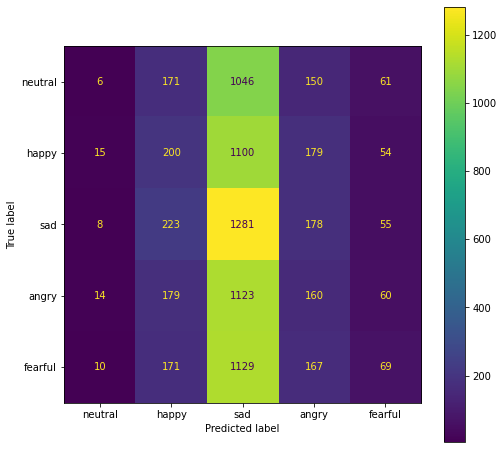

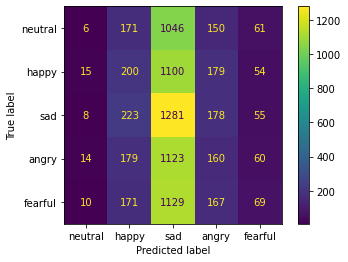

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
labels = ['neutral','happy','sad','angry','fearful']
## Display the visualization of the Confusion Matrix.
y_pred = model.predict(X_test).argmax(axis=1)
# print(y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,8))
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
ax = ConfusionMatrixDisplay.from_predictions( y_test,y_pred, display_labels=labels).plot(ax=ax)


In [ ]:
from tensorflow import keras
old = keras.models.load_model('cnn_63.h5')
old.summary()

In [ ]:
from IPython.display import Image 
from keras.utils import vis_utils

vis_utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

# Image('model.png')


